## Visualize the Optimization Process

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
from matplotlib.pyplot import figure



In [12]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = 1000, 
                                           shuffle=True)
    return train_loader

def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=1000, 
                                          shuffle=False)
    return test_loader
print("Train_dataset size:", len(train_dataset),"\nTest_dataset size:", len(test_dataset))


Train_dataset size: 60000 
Test_dataset size: 10000


In [13]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
#train function
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('Training started')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt = pd.DataFrame()
    trainAvgLossArr = []
    trainAvgAccArr = []
    firstParaWgt = {}

    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0
        epoch_df = pd.DataFrame()

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            optimizer.zero_grad()
            # Forward pass
            prediction = model(images)
            images.requires_grad = True
            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()
            # Backward and optimize         
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Training   : Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r')
        
        #Weight Collection
        for name, parameter in model.named_parameters():
            #print(name)
            if'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
                epoch_df = pd.concat([epoch_df, pd.DataFrame(weights).T], axis = 1) 

        modelParamWgt = pd.concat([modelParamWgt, epoch_df], axis = 0)     

       
        epochLoss = lossSum/n_total_steps
        epochAcc = totalacc/n_total_steps
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt


In [15]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r')
    return netTest_acc1, netTest_loss

In [16]:
n_param=[]
dnn1 = DNN()
for i in dnn1.parameters():
    n_param.append(torch.numel(i))
print(f'Total no of parameters:{np.sum(n_param)}')

Total no of parameters:418060


In [189]:
print(dnn1)

DNN(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [18]:
max_epochs = 45
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 1000
test_batch_size = 1000
status_interval = 60
loss_func = nn.CrossEntropyLoss()
firstLayer = pd.DataFrame()

for count in range(8):
    j = copy.deepcopy(count)
    j = DNN()  
    print("Time: "+str(count))
    optimizer = torch.optim.Adam(j.parameters(),lr = 0.0001,weight_decay=1e-4)
    model_name1 = "Times:"+str(count)  
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt = trainFunc(j,max_epochs,train_loader,status_interval)
    testAcc, testLoss = testFunction(j,loss_func,test_batch_size)

    all_df = pd.concat([all_df, modelParamWgt], ignore_index=True)
    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr

Time: 0
Training started
Time: 1y of the network on the test images: 98.12% & Test Loss: 0.06041333051398397
Training started
Time: 2y of the network on the test images: 98.08% & Test Loss: 0.060044348053634164
Training started
Time: 3y of the network on the test images: 98.05% & Test Loss: 0.06339300032705068
Training started
Time: 4y of the network on the test images: 98.12% & Test Loss: 0.06269195629283786
Training started
Time: 5y of the network on the test images: 98.02% & Test Loss: 0.06524213645607232
Training started
Time: 6y of the network on the test images: 98.0% & Test Loss: 0.06257433099672198
Training started
Time: 7y of the network on the test images: 98.15% & Test Loss: 0.0634900914505124
Training started


In [19]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])
print(all_df)
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')
t1 = all_df
print(pd.DataFrame(t1))


              0             1             2             3             4    \
0   -2.644949e-04 -3.537234e-05  8.548678e-05 -8.165441e-05 -2.020884e-05   
1    3.948979e-05 -4.866847e-06 -7.637493e-06  3.884914e-06  8.690948e-06   
2   -2.350328e-07  2.156727e-07 -3.553702e-07  3.192353e-08  6.144446e-07   
3   -6.135751e-08 -1.619929e-09 -9.549265e-09  5.529757e-10 -3.366739e-08   
4   -3.117902e-09 -3.496969e-10  6.030364e-10  2.784233e-10  1.463999e-09   
..            ...           ...           ...           ...           ...   
355 -1.012288e-38 -1.618503e-38 -9.813861e-39  1.363804e-38 -5.905073e-39   
356 -1.012288e-38 -1.618503e-38 -9.813861e-39  1.363804e-38 -5.905073e-39   
357 -1.012288e-38 -1.618503e-38 -9.813861e-39  1.363804e-38 -5.905073e-39   
358 -1.012288e-38 -1.618503e-38 -9.813861e-39  1.363804e-38 -5.905073e-39   
359 -1.012288e-38 -1.618503e-38 -9.813861e-39  1.363804e-38 -5.905073e-39   

              5             6             7             8             9    

In [20]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)
    pcaVal = pcaOperation.fit_transform(paramDF)
    itrData = np.full((pcaVal.shape[0],1),itr)
    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])
    return pcaDf


In [45]:
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)
allEpochDf = pd.DataFrame(new_data,columns=['x','y'])
eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['Epoch']=eps_each_time
allEpochDf['Iteration']=(times)
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

print(allEpochDf)
epoch3Df = allEpochDf.loc[(allEpochDf['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
print(epoch3Df)


            x          y  Epoch  Iteration        Acc      Loss
0   -1.894482   1.526771      0          0  50.186118  1.332190
1   -2.345546   1.852000      1          0  88.222691  0.399453
2   -2.621713   2.052901      2          0  91.140650  0.298663
3   -2.845823   2.216753      3          0  92.436262  0.257039
4   -3.041635   2.367574      4          0  93.544159  0.226864
..        ...        ...    ...        ...        ...       ...
355  1.973913  12.130998     40          7  99.589320  0.021343
356  1.969100  12.105392     41          7  99.719770  0.020002
357  1.967015  12.080326     42          7  99.727790  0.018760
358  1.961639  12.052354     43          7  99.681879  0.018192
359  1.958704  12.020760     44          7  99.746127  0.017328

[360 rows x 6 columns]
            x          y  Epoch  Iteration        Acc      Loss
0   -2.621713   2.052901      2          0  91.140650  0.298663
1   -3.215788   2.504078      5          0  94.145111  0.202111
2   -3.609327   

In [22]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
len(mv)

120

### Plot PCA

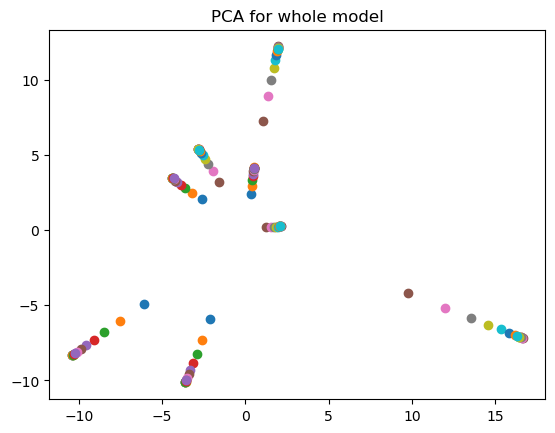

In [194]:
for i in range(len(mv)):
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker='o')
    plt.title("PCA for whole model")
    
# plt.figure(figsize=[10,5])
plt.savefig('pcaModel.png')
plt.show()

### PCA for Single Layer

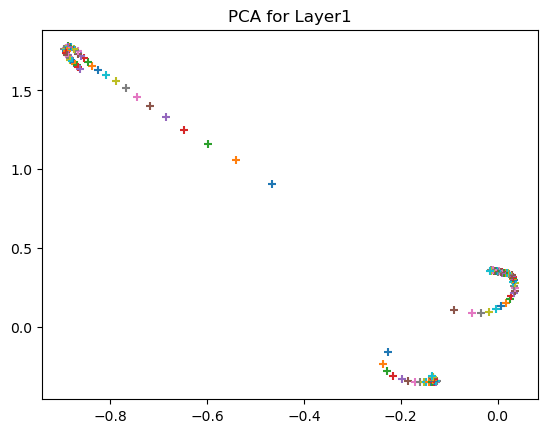

In [47]:
layer1_Df = all_df.iloc[:,0:7840]
t2 = layer1_Df 
t2 = np.array(t2)
pca = PCA(n_components=2)
new_data2 = pca.fit_transform(t2)

layer1Df = pd.DataFrame(new_data2,columns=['x','y'])
eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

layer1Df['Epoch']=eps_each_time
layer1Df['Iteration']=(times)
layer1Df["Acc"] = train_acc_data
layer1Df["Loss"] = train_loss_data

for i in range(len(mv)):
    plt.scatter(layer1Df['x'][i],layer1Df['y'][i],marker='+')
    plt.title("PCA for Layer1")

plt.savefig('PCA_Layer1.png')
plt.show()

## Visualize the Optimization Process

In [54]:
#Assume our nonlinear Sinc function
x = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1) 
y = (np.sin(5*np.pi*x))/(5*np.pi*x) 
print(x.shape,y.shape)

#x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
x = x.clone().detach()
y = y.clone().detach()
n_samples, n_features = x.shape


torch.Size([300, 1]) torch.Size([300, 1])


In [196]:
class M1(nn.Module):
    def __init__(self,):
        super(M1, self).__init__()
        self.fc1 = nn.Linear(1, 500)
        self.fc2 = nn.Linear(500, 1)

    def forward(self, x):
        # flatten as one dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [73]:
def trainFunc(model,x,y):
    max_epoch = 5000
    epoch_arr,loss_arr=[],[]
    isConverged = False
    epoch = 0
    gradArr = []
    while isConverged==False:
        epoch += 1
        prediction = model(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step() 
        
        epoch_arr.append(epoch)
        loss_arr.append(loss.detach().numpy())

        #Generating Gradient Norm
        grad_all = 0.0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5         
        gradArr.append(grad_norm)
        
        if epoch%500 == 0 : print(f'epoch: {epoch}, loss = {loss.item():.4f}, grad_norm = {grad_norm}') #, weight = {model.weight.item()},  bias ={model.bias.item()}')
        if epoch == max_epoch:
                print("Max Epoch Reached")
                break
        elif (epoch > 5) and  (loss_arr[-1] < 0.001):
            if abs(loss_arr[-3] - loss_arr[-2]) < 1.0e-05 and abs(loss_arr[-2] - loss_arr[-1]) < 1.0e-05:
                print("Convergeance reached for loss:",loss_arr[-1])
                break
        
        
                
    return epoch_arr,loss_arr,prediction,grad_norm,gradArr

In [74]:
torch.manual_seed(1)
m1 = M1()     # define the network
optimizer = torch.optim.Adam(m1.parameters(), lr=1e-4, weight_decay = 1e-4)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

a=[]
for i in m1.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 1:', np.sum(a),)
M1epoch_arr,M1loss_arr,M1prediction,M1grad_norm,M1gradArr = trainFunc(m1,x,y)

Total no of parameters in Model 1: 1501
epoch: 500, loss = 0.0590, grad_norm = 0.05136635242607349
epoch: 1000, loss = 0.0424, grad_norm = 0.03661318349596279
epoch: 1500, loss = 0.0279, grad_norm = 0.029306211842592664
epoch: 2000, loss = 0.0173, grad_norm = 0.02154561239149089
epoch: 2500, loss = 0.0111, grad_norm = 0.014726571371693744
epoch: 3000, loss = 0.0075, grad_norm = 0.009959372587828462
epoch: 3500, loss = 0.0055, grad_norm = 0.0068212949037145
epoch: 4000, loss = 0.0042, grad_norm = 0.005127967279631439
epoch: 4500, loss = 0.0032, grad_norm = 0.004152102648647062
epoch: 5000, loss = 0.0024, grad_norm = 0.0034227616907707412
Max Epoch Reached


In [195]:
print(m1)

M1(
  (fc1): Linear(in_features=1, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1, bias=True)
)


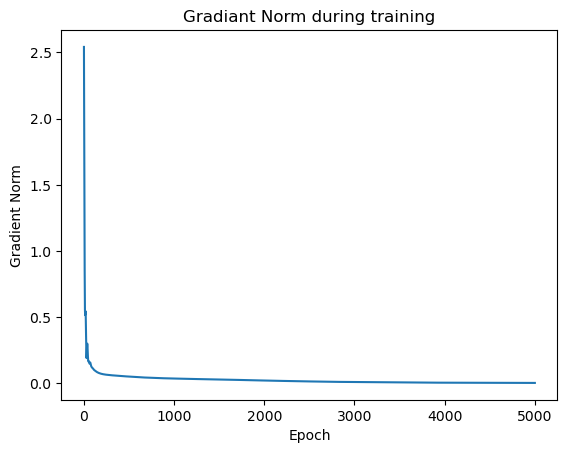

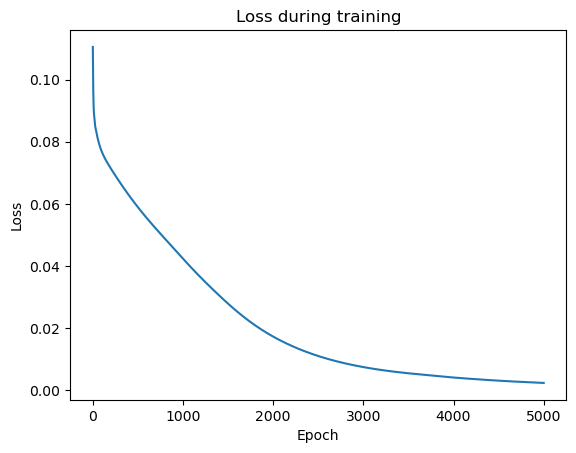

In [77]:
plt.plot(M1epoch_arr,M1gradArr)
plt.title('Gradiant Norm during training')
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.savefig('GradientNorm.png')
plt.show()

plt.plot(M1epoch_arr,M1loss_arr)
plt.title('Loss during training')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('Loss.png')
plt.show()

3.What Happened When Gradient is Almost Zero

In [79]:
!pip install autograd_lib
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from autograd_lib import autograd_lib
from torch.utils.data import DataLoader, TensorDataset

In [80]:
Y_func = lambda x : (torch.sin(5*np.pi*x)) /(5*np.pi*x) 
num_of_rows = 300
X= torch.unsqueeze(torch.linspace(-1,1,num_of_rows),dim=1)
Y = Y_func(X)
dataset = TensorDataset(X,Y)
data_loader = DataLoader(dataset,1,shuffle=True)

In [158]:
class MathRegressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x
    
    def training_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def train_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'train_loss': loss.detach()}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'train_loss': epoch_loss.item()}
    
    

In [159]:
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) 
    return grad_mean

def save_activations(layer, A, _):
    activations[layer] = A

def compute_hess(layer, _, B):
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) 
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA)

, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L')

def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig =torch.linalg.eigvalsh(h, 'L')
        minimum_ratio.append(torch.sum(h_eig>0).item()/ len(h_eig))

    ratio_mean = np.mean(minimum_ratio) 
    return ratio_mean


In [170]:
def get_norm_minimal_ratio(model,criterion):

    gradient_norm = compute_gradient_norm(model, criterion, X, Y)
    minimum_ratio = compute_minimum_ratio(model, criterion, X, Y)
    result = {}
    result["grad_norm"] = gradient_norm
    result["ratio"] = minimum_ratio
    
    return result

In [171]:
def evaluate(model,loss_fn, val_loader):
    outputs = [model.validation_step(batch,loss_fn) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate2(model,loss_fn, train_loader):
    outputs = [model.train_step(batch,loss_fn) for batch in train_loader]
    return model.train_epoch_end(outputs)

def get_grad_norm(model):
    grad_all=0.0
    grad =0   
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
            
        grad_all+=grad
        
    grad_norm=grad_all ** 0.5
    return grad_norm

def fit(epochs, lr, model, data_loader, criterion,opt_func):
    history = []
    comparing_epoch_loss =1000.0
    grad_norm_per_epoch={}
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        prediction = model(X)
        loss = criterion(prediction, Y)
        loss.backward()
        grad_norm_per_epoch[epoch] = get_norm_minimal_ratio(model,criterion)
        optimizer.step() 
        optimizer.zero_grad()
        result = evaluate(model,criterion, data_loader)
        #model.epoch_end(epoch, result)
        history.append(result)
        if epoch == 900:
            comparing_epoch_loss= result["val_loss"]
    return history,grad_norm_per_epoch,model

In [203]:
num_of_rows = 300
lr = 0.0001
gamma_lr_scheduler = 0.1 
weight_decay = 1e-4

In [204]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =5000
input_size=1
output_size=1
model= MathRegressor()

In [205]:
autograd_lib.register(model)
activations = defaultdict(int)
hess = defaultdict(float)  

In [206]:
result_1 = evaluate(model,criterion,data_loader)

In [207]:
train,target = X,Y

In [208]:
model_1 = M1()   #Use the same simpler DNN model as previous exercise
history_1,grad_norm_1,model  = fit(num_epochs, lr, model, data_loader, criterion,optimizer)

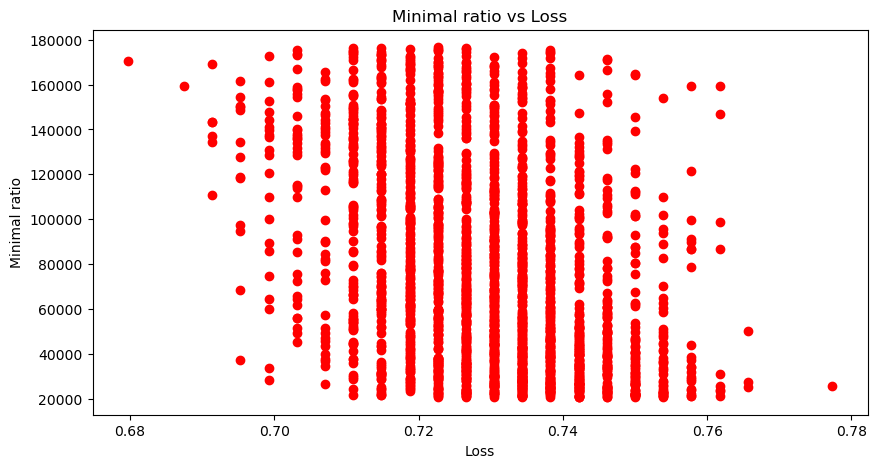

In [198]:
val_losses_1 = [r['val_loss'] for r in history_1]
minimal_ratio_eps = [i['ratio'] for i in grad_norm_1.values() ]

plt.figure(figsize=(10,5))
plt.scatter(minimal_ratio_eps,val_losses_1,color = 'red')
plt.xlabel('Loss')
plt.ylabel('Minimal ratio')
plt.title('Minimal ratio vs Loss');
plt.plot()
plt.savefig('gradZero.png')
